In [2]:
%pip install wfdb numpy pandas matplotlib tensorflow imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
import wfdb


In [4]:
import os
import wfdb
import numpy as np
import pandas as pd

data = './mitdb1'


patients = [f.split('.')[0] for f in os.listdir(data) if f.endswith('.hea')]
patients = np.sort(patients)
labels_df = pd.DataFrame()

for pat_id in patients:
    file = os.path.join(data, pat_id)
    annotation = wfdb.rdann(file, 'atr')

    #sym is the annotated symbol read from the file
    labels = annotation.symbol

    #values is the different symbols in each patient
    #counts is the number of each symbol for said patient
    vals, cts = np.unique(labels, return_counts=True)

    #df_sub is a mini lil dataframe for each individual patient
    df_per_pat = pd.DataFrame({'Symbol':vals, 'Counts':cts, 'Patient':[pat_id]*len(cts)})
    labels_df = pd.concat([labels_df, df_per_pat],axis = 0)

labels_df.groupby('Symbol').Counts.sum().sort_values(ascending = False)

Symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

In [5]:
print(np.unique(labels_df.Symbol))
print(len(np.unique(labels_df.Symbol)))

['!' '"' '+' '/' 'A' 'E' 'F' 'J' 'L' 'N' 'Q' 'R' 'S' 'V' '[' ']' 'a' 'e'
 'f' 'j' 'x' '|' '~']
23


In [6]:
# For first stage, consider N as normal heartbeats, all others are irregular or noise (according to found article).
other = ['/','f','j','a']
normal = ['N','L','R','e']
ventricular = ['V','E']
supraventricular = ['S','J','A','a']
fusion = ['F']

#AAMI_labels = [['N', 'L', 'R', 'e'], ['V', 'E'], ['S', 'J', 'A', 'a'], ['F'], ['/', 'f', 'j', 'a']]
#classes = [label for sublist in AAMI_labels for label in sublist]

AAMI_labels = [['N', 'L', 'R', 'e'], ['V', 'E'], ['S', 'J', 'A', 'a'], ['F'], ['/', 'f', 'j', 'a']]

# Define your classes
classes = ['Normal', 'Ventricular', 'Supraventricular', 'Fusion', 'Other']




In [7]:
def categorize_heartbeat(symbol):

    if symbol in normal:
        return 0

    elif symbol in ventricular:
        return 1

    elif symbol in supraventricular:
        return 2

    elif symbol in fusion:
        return 3

    else:
        return 4

In [8]:
# used to load in the entire ECG dataset,
# get the signal and label,
# read the symbols and signal

def load_ecg(file):

    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal
    symbol_ann = annotation.symbol
    sample_ann = annotation.sample

    return p_signal, symbol_ann, sample_ann

In [9]:
# creates dataset for model training

def make_dataset(patients, seconds, frequency, classes):

  #set number of data points
  columns = 2 * seconds * frequency
  data_X = np.zeros((1,columns))
  data_Y = np.zeros((1,len(classes)))
  data_Labels = []

  rows_per_patient = []

  for pat in patients:
    file = os.path.join(data, pat)
    p_signal, symbol_ann, sample_ann = load_ecg(file)

    # only using one lead for simplicity
    p_signal = p_signal[:,0]

    # make df without the noise symbols
    df_data = pd.DataFrame({'symbol_ann':symbol_ann, 'sample_ann':sample_ann})
    #df_data = df_data.loc[df_data.symbol_ann.isin(classes)]
    df_data['symbol_ann'] = df_data['symbol_ann'].apply(lambda x: next((class_name for class_name, label_list in zip(classes, AAMI_labels) if x in label_list), 'Other'))



    rows = len(df_data)
    X = np.zeros((rows, columns))
    Y = np.zeros((rows,len(classes)))
    symbs = []

    # keep track of rows
    maximum_rows = 0

    for sample_ann, symbol_ann in zip(df_data.sample_ann.values,df_data.symbol_ann.values):
        left = max([0,(sample_ann - seconds * frequency) ])
        right = min([len(p_signal),(sample_ann + seconds * frequency) ])
        x = p_signal[left: right]
        if len(x) == columns:
            X[maximum_rows,:] = x
            class_index = classes.index(symbol_ann)
            Y[maximum_rows, class_index] = 1
            maximum_rows += 1

    X = X[:maximum_rows,:]
    Y = Y[:maximum_rows,:]

    data_Labels += df_data['symbol_ann'].tolist()
    data_X = np.append(data_X,X,axis = 0)
    data_Y = np.append(data_Y,Y,axis = 0)

  data_X = data_X[1:,:]
  data_Y = data_Y[1:,:]

  return data_X, data_Y, data_Labels

In [10]:
X_data, Y_data, symbol_data = make_dataset(patients, 3, 360, classes)


In [11]:
ydffg = pd.DataFrame(Y_data)

label_counts = ydffg.iloc[:, 0:].sum()
print(label_counts)

0    90098.0
1     7219.0
2     2771.0
3      801.0
4    11344.0
dtype: float64


In [12]:
from sklearn.model_selection import train_test_split



X_train, X_valid, y_train, y_valid = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)

In [13]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)

In [14]:
df4 = pd.DataFrame(X_train_resample)

df4

,0,1,2,3,4,5,6,7,8,9,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
0,-0.825000,-0.815000,-0.805000,-0.805000,-0.795000,-0.785000,-0.760000,-0.765000,-0.740000,-0.710000,...,-0.520000,-0.525000,-0.525000,-0.530000,-0.540000,-0.550000,-0.550000,-0.540000,-0.545000,-0.535000
1,-0.370000,-0.370000,-0.365000,-0.350000,-0.335000,-0.320000,-0.300000,-0.265000,-0.255000,-0.250000,...,-0.265000,-0.285000,-0.300000,-0.300000,-0.295000,-0.270000,-0.255000,-0.255000,-0.250000,-0.230000
2,-0.225000,-0.220000,-0.215000,-0.220000,-0.235000,-0.270000,-0.270000,-0.275000,-0.265000,-0.250000,...,-0.340000,-0.330000,-0.320000,-0.325000,-0.335000,-0.340000,-0.330000,-0.325000,-0.315000,-0.335000
3,-0.260000,-0.260000,-0.270000,-0.260000,-0.250000,-0.255000,-0.245000,-0.250000,-0.255000,-0.250000,...,-0.375000,-0.365000,-0.360000,-0.345000,-0.330000,-0.320000,-0.310000,-0.320000,-0.310000,-0.325000
4,-0.640000,-0.645000,-0.640000,-0.615000,-0.600000,-0.575000,-0.580000,-0.585000,-0.585000,-0.585000,...,-0.880000,-0.880000,-0.885000,-0.880000,-0.880000,-0.875000,-0.870000,-0.870000,-0.880000,-0.895000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315020,0.157203,0.142481,0.127760,0.123038,0.143317,0.163038,0.183595,0.199152,0.209152,0.219152,...,0.171646,0.181089,0.189696,0.185810,0.166924,0.138873,0.128317,0.123038,0.133595,0.119709
315021,-0.231962,-0.208038,-0.188924,-0.176962,-0.173038,-0.173924,-0.181962,-0.166962,-0.151962,-0.141076,...,-0.305886,-0.304809,-0.309809,-0.315886,-0.316962,-0.306962,-0.292848,-0.290886,-0.299809,-0.303733
315022,-0.285249,-0.291013,-0.293894,-0.295421,-0.300421,-0.304657,-0.294486,-0.291605,-0.292960,-0.290078,...,-0.015763,-0.005763,-0.005934,-0.001698,0.004066,0.006184,0.012710,0.025592,0.045000,0.057882
315023,-0.171031,-0.171490,-0.176031,-0.173761,-0.176490,-0.166949,-0.154219,-0.161949,-0.171949,-0.169678,...,-0.152316,-0.155504,-0.150046,-0.137775,-0.123234,-0.131422,-0.139610,-0.139151,-0.134151,-0.124151


In [15]:
print(X_train_resample.shape)
print(y_train_resample.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_data.shape)

(315025, 2160)
(315025, 5)
(33670, 2160)
(33670, 5)
(112233, 2160)


In [16]:
ydffgtr = pd.DataFrame(y_train_resample)

label_counts = ydffgtr.iloc[:, 0:].sum()
print(label_counts)

0    63005
1    63005
2    63005
3    63005
4    63005
dtype: int64


In [17]:
X_train_cnn = np.reshape(X_train_resample, (X_train_resample.shape[0], X_train_resample.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)

(315025, 2160, 1)


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(2160,1)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(classes), activation='softmax'))  # softmax for multiclass classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_cnn, y_train_resample, epochs=2, validation_data=(X_valid_cnn, y_valid))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_valid_cnn, y_valid)
print(f"Test Accuracy: {test_accuracy}")

2024-02-11 14:40:50.381953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 14:40:52.635914: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-11 14:40:53.292081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-11 14:40:53.292112: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Epoch 1/2
9845/9845 [==============================] - 952s 97ms/step - loss: 0.0591 - accuracy: 0.9812 - val_loss: 0.1153 - val_accuracy: 0.9778
Epoch 2/2
1053/1053 [==============================] - 23s 22ms/step - loss: 0.1477 - accuracy: 0.9767
Test Accuracy: 0.9766854643821716


In [24]:
%pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


1053/1053 [==============================] - 23s 22ms/step


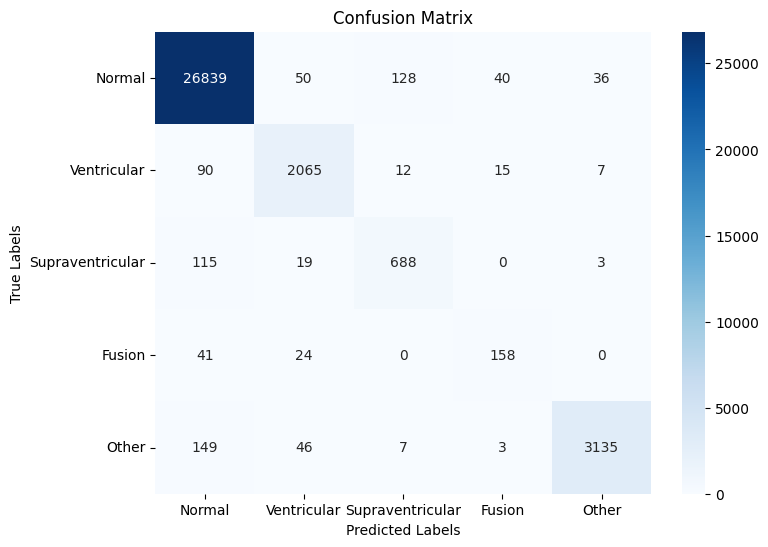

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_valid_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_valid from one-hot encoded to class labels
y_valid_classes = np.argmax(y_valid, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid_classes, y_pred_classes)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,  # Replace with your class labels
            yticklabels=classes)  # Replace with your class labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [1]:
from sklearn.metrics import classification_report


ModuleNotFoundError: No module named 'sklearn'